# Pycox: DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-CC (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ! pip install sklearn-pandas
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

os.chdir("../")
from scr.utils import *
from scr.runDeepSurvModels import *

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

Event rate in train set: 0.752778
Event rate in test set: 0.753000
Survival time distribution:


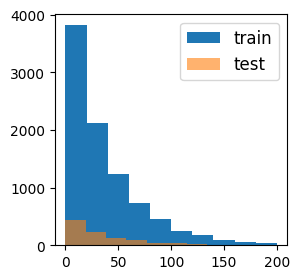

In [63]:
# prepare data
folder = 'nonlinear'
keywords = ['sine', "latest", 'RW']
DATANAME = 'nl-sine-RW'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)

print("Event rate in train set: %f" % (sum(train_df['status']==1) / train_df.shape[0]))
print("Event rate in test set: %f" %  (sum(test_df['status']==1) / test_df.shape[0]))
print('Survival time distribution:')
_, ax = plt.subplots(figsize=(3,3))
ax.hist(train_df['time'], label='train')
# ax.hist(val_df['time'],   label='val', alpha=.8)
ax.hist(test_df['time'], label='test', alpha=0.6)
ax.legend(fontsize=12)
plt.show()

## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [ ]:

subset = [50, 500, 2000, 5000, 8000]

In [47]:
## Full training set
val_size = 0.2
random_state = 42
train_df, val_df = train_test_split(train_df, 
                                        test_size=val_size,
                                        shuffle=True, random_state=random_state,
                                        stratify=train_df['status'])

In [48]:
survival_cols = ['time','status']
covariate_cols = [col for col in train_df.columns if col not in survival_cols]

standardize = [([col], StandardScaler()) for col in covariate_cols]
leave = [(col, None) for col in survival_cols]
x_mapper = DataFrameMapper(standardize + leave)

# transform data 
x_train = x_mapper.fit_transform(train_df).astype('float32')
x_val = x_mapper.fit_transform(val_df).astype('float32')
x_test = x_mapper.transform(test_df).astype('float32')

# prepare labels
get_target = lambda df: (df['time'].values, df['status'].values)
y_train = get_target(train_df)
y_val = get_target(val_df)
t_test, e_test = get_target(test_df)
val = x_val, y_val

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [49]:
in_features = x_train.shape[1]
num_nodes = [32, 16]
out_features = 1
batch_norm = True
dropout = 0.2
output_bias = True

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                            dropout, output_bias=output_bias)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

0.0001

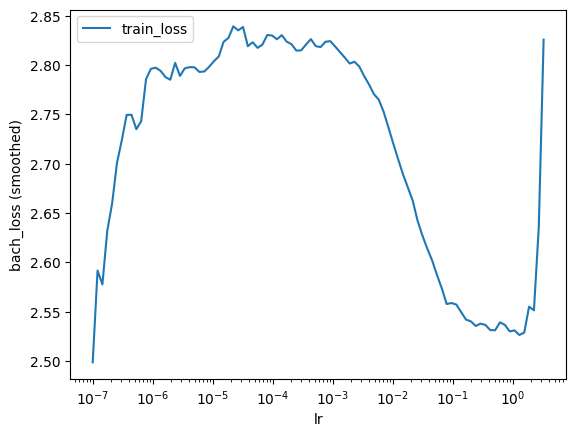

In [50]:
# optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, 
#                             cycle_eta_multiplier=0.8,
#                             cycle_multiplier=2)
optimizer = tt.optim.Adam(weight_decay=0.01)
model = CoxPH(net, optimizer)
# model.optimizer.set_lr(1e-3)

batch_size = 32
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

best_lr = lrfinder.get_best_lr()
best_lr

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [51]:
model.optimizer.set_lr(best_lr)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [52]:
%%time
batch_size = 64
epochs = 500
callbacks = [tt.callbacks.EarlyStopping(patience=20, min_delta=5e-2)]
verbose = True

log = model.fit(x_train, y_train,
                batch_size,
                epochs,
                callbacks, 
                verbose=True,
                val_data=val, val_batch_size=batch_size
                )

0:	[0s / 0s],		train_loss: 3.3462,	val_loss: 3.1485
1:	[0s / 0s],		train_loss: 3.1216,	val_loss: 2.9746
2:	[0s / 0s],		train_loss: 2.9844,	val_loss: 2.8325
3:	[0s / 0s],		train_loss: 2.8724,	val_loss: 2.7380
4:	[0s / 1s],		train_loss: 2.7700,	val_loss: 2.6435
5:	[0s / 1s],		train_loss: 2.6785,	val_loss: 2.5475
6:	[0s / 1s],		train_loss: 2.6045,	val_loss: 2.4718
7:	[0s / 1s],		train_loss: 2.5125,	val_loss: 2.3703
8:	[0s / 1s],		train_loss: 2.4390,	val_loss: 2.3264
9:	[0s / 2s],		train_loss: 2.3662,	val_loss: 2.2239
10:	[0s / 2s],		train_loss: 2.3169,	val_loss: 2.1802
11:	[0s / 2s],		train_loss: 2.2670,	val_loss: 2.1291
12:	[0s / 2s],		train_loss: 2.2258,	val_loss: 2.0814
13:	[0s / 3s],		train_loss: 2.1818,	val_loss: 2.0420
14:	[0s / 3s],		train_loss: 2.1492,	val_loss: 2.0136
15:	[0s / 3s],		train_loss: 2.1071,	val_loss: 1.9492
16:	[0s / 3s],		train_loss: 2.0814,	val_loss: 1.9488
17:	[0s / 3s],		train_loss: 2.0368,	val_loss: 1.9004
18:	[0s / 4s],		train_loss: 2.0080,	val_loss: 1.8623
19:

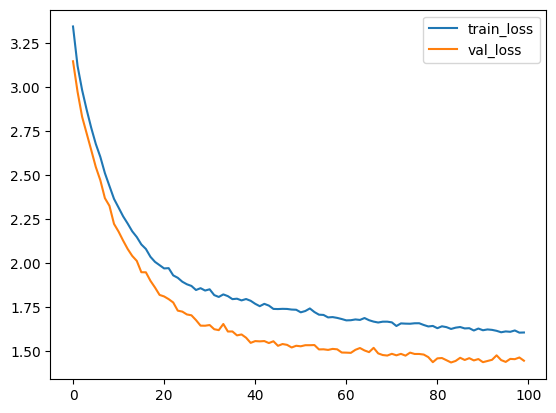

In [53]:
_ = log.plot()

We can get the partial log-likelihood

In [54]:
model.partial_log_likelihood(x_train, y_train).mean()

-5.7513976

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as `CoxPH` is semi-parametric, we first need to get the non-parametric baseline hazard estimates with `compute_baseline_hazards`. 

Note that for large datasets the `sample` argument can be used to estimate the baseline hazard on a subset.

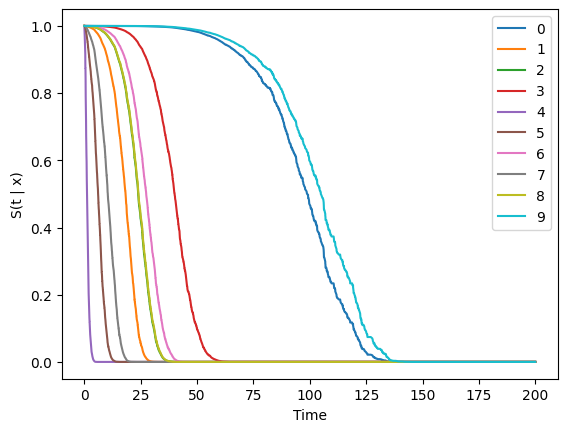

In [55]:
_ = model.compute_baseline_hazards()
te_surv = model.predict_surv_df(x_test)
tr_surv = model.predict_surv_df(x_train)
# plot predicted KM for first 5 observations
te_surv.iloc[:, :10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [62]:
test_df.reset_index(drop=True).iloc[:10, -2:]

,time,status
0,84.395556,0
1,18.982680,1
2,25.428697,1
3,39.231693,1
4,0.179018,1
5,5.660309,1
6,10.389598,0
7,3.653403,0
8,23.488279,1
9,106.036036,1


## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [56]:
train_ev = EvalSurv(tr_surv, y_train[0], y_train[1], censor_surv='km')
train_c  = train_ev.concordance_td()
test_ev  = EvalSurv(te_surv, t_test, e_test, censor_surv='km')
test_c   = test_ev.concordance_td()

print(f"Train C-Index: {round(train_c, 3)} | Test C-index: {round(test_c,3)}")

Train C-Index: 0.988 | Test C-index: 0.98


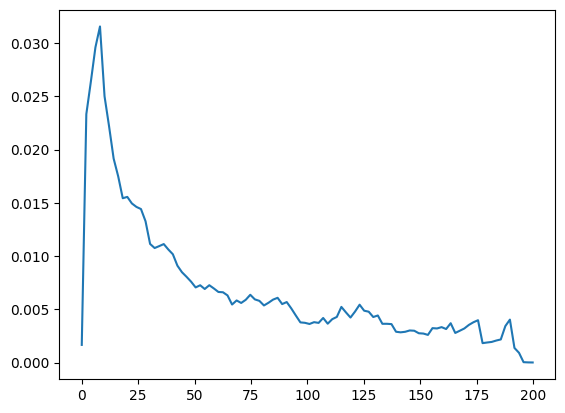

In [40]:
time_grid = np.linspace(t_test.min(), t_test.max(), 100)
_ = test_ev.brier_score(time_grid).plot()

In [41]:
print(test_ev.integrated_brier_score(time_grid))

0.006980182300931505
